#Healthcare Sales Wizard Sales Territory Optimization

Applied Data Science Fall 2024

Prof. Scrivner

Team Members:



*   Erik Kreider
*   Ian Boen
*   Owen Randolph

Notebook by Ian Boen




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('healthcare_sales_dataset.csv')

In [3]:
df.head()

product_id   company_id transaction_id       product_name  \
0  PMFTMGPWLK  hospital_20     KH9NHAKRFF      Gauze Sponges   
1  B2L09J6I8B     clinic_3     6XGV4E1D36     Scalpel Blades   
2  TLJFSQ5K16    clinic_10     OGEAMK0FW0  Disposable Gloves   
3  3BDN23AHDX   hospital_2     Y68IXY4B8S     Syringes, 50ml   
4  3BDN23AHDX     clinic_8     3GU73WIOON     Syringes, 50ml   

    product_category  sale_amount  quantity_sold  price_per_unit     uom  \
0    Medical Devices       463.07             85            5.45   packs   
1  Surgical Supplies       387.87             12           32.32  pieces   
2    Medical Devices       336.95             26           12.96   boxes   
3  Surgical Supplies       254.99             17           15.00   boxes   
4    Medical Devices       291.24             66            4.41   boxes   

           address     region customer_segment      sales_rep_name  \
0   Washington, DC  Northeast         Hospital  Christopher Flores   
1      Chicago, IL    Midwest           Clinic          John Ponce   
2  Minneapolis, MN    Midwest           Clinic        Thomas Silva   
3       Boston, MA  Northeast         Hospital         Megan Chang   
4  Los Angeles, CA       West           Clinic    William Sullivan   

  date_of_sale  multiple_items  
0     8/5/2024               0  
1    4/22/2024               1  
2    9/30/2024               1  
3    5/20/2024               0  
4    5/13/2024               1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        10000 non-null  object 
 1   company_id        10000 non-null  object 
 2   transaction_id    10000 non-null  object 
 3   product_name      10000 non-null  object 
 4   product_category  10000 non-null  object 
 5   sale_amount       10000 non-null  float64
 6   quantity_sold     10000 non-null  int64  
 7   price_per_unit    10000 non-null  float64
 8   uom               10000 non-null  object 
 9   address           10000 non-null  object 
 10  region            10000 non-null  object 
 11  customer_segment  10000 non-null  object 
 12  sales_rep_name    10000 non-null  object 
 13  date_of_sale      10000 non-null  object 
 14  multiple_items    10000 non-null  int64  
dtypes: float64(2), int64(2), object(11)
memory usage: 1.1+ MB


In [5]:
df.describe()

sale_amount  quantity_sold  price_per_unit  multiple_items
count  10000.000000   10000.000000    10000.000000    10000.000000
mean     248.864717      40.619700        9.648196        0.725800
std      135.647920      21.914851       13.229527        0.446133
min       10.060000       1.000000        0.210000        0.000000
25%      133.602500      23.000000        3.430000        0.000000
50%      231.460000      40.000000        6.000000        1.000000
75%      365.560000      57.000000       10.482500        1.000000
max      499.950000     117.000000      198.420000        1.000000

##Exploratory Data Analysis

Distribution and Outlier Analysis

We'll standardize the numerical features for ```sale_amount```, ```quanity_sold```, and ```price_per_unit``` so we can easily compare the boxplots.

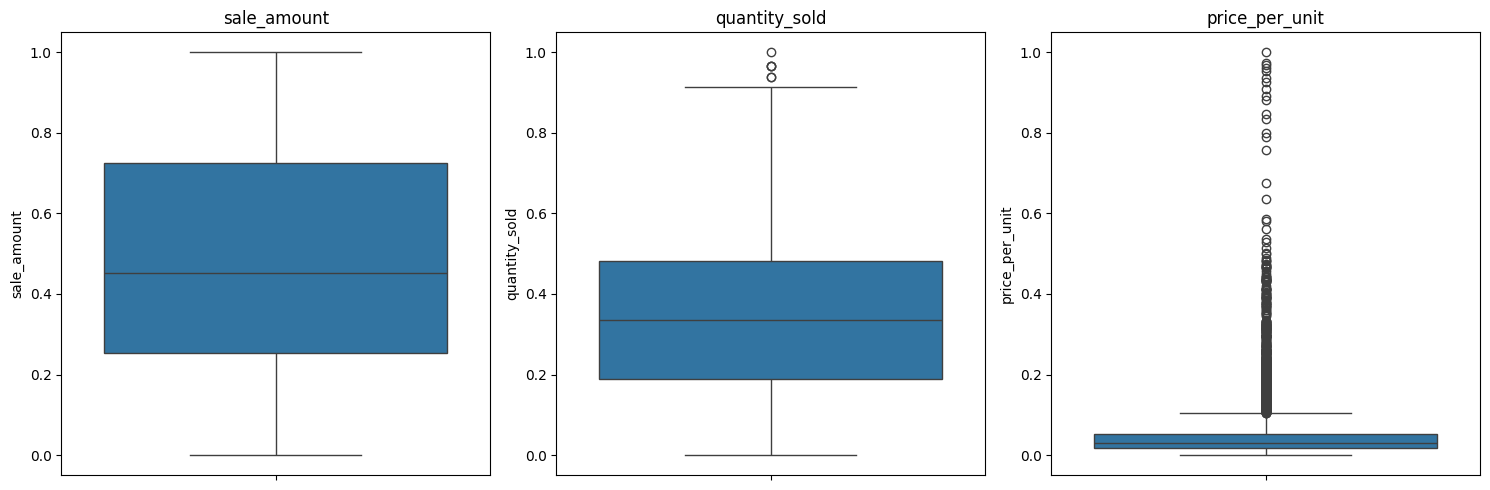

In [6]:
from sklearn.preprocessing import MinMaxScaler

data = {'sale_amount': df['sale_amount'],
        'quantity_sold': df['quantity_sold'],
        'price_per_unit': df['price_per_unit'],}

df_numeric = pd.DataFrame(data)

#Normalize Data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Boxplots for each subplot
features = df_scaled.columns
for i, ax in enumerate(axes):
  sns.boxplot(df_scaled, y=features[i], ax=ax)
  ax.set_title(features[i])

plt.tight_layout()
plt.show()

It looks like ```quantity_sold``` has a few outliers in the upper range, and ```price_per_unit``` appears to have an extensive amount of outliers in the upper range relative to its IQR.

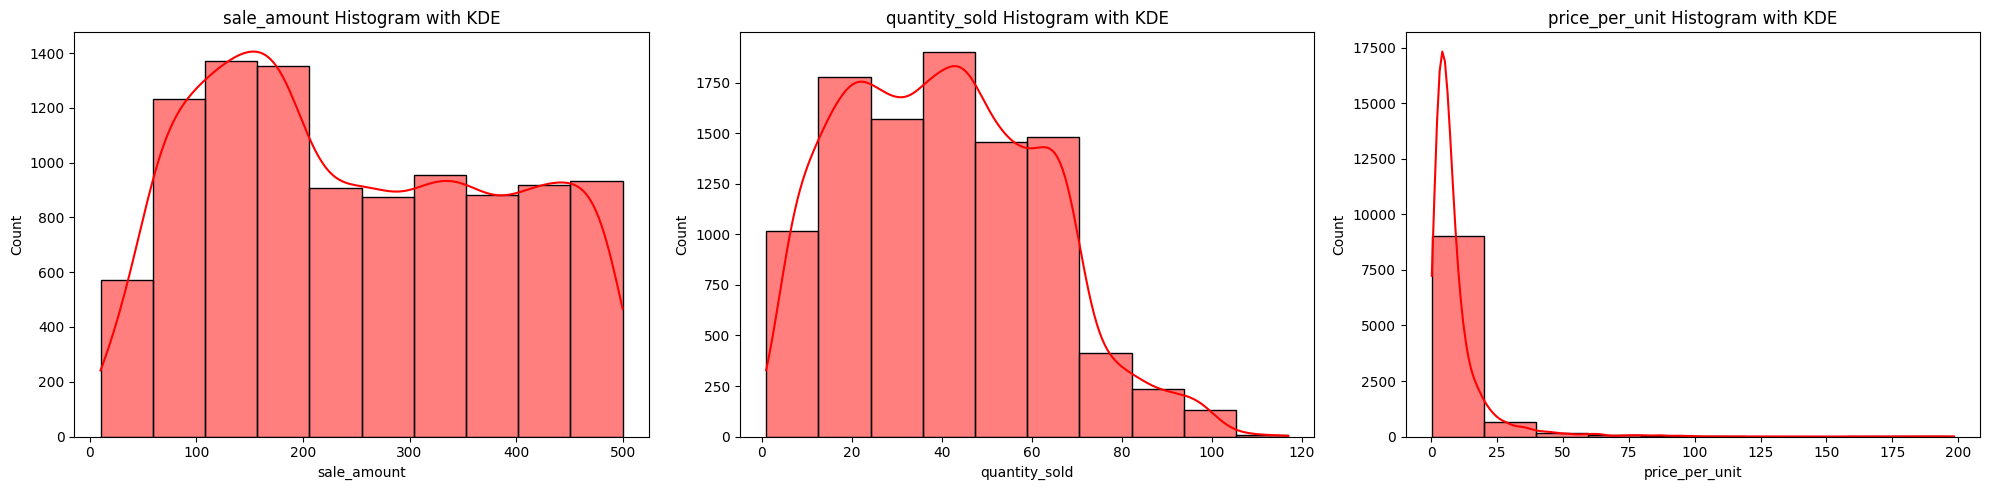

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

features = df_numeric.columns
for i, ax in enumerate(axes):
  sns.histplot(df, x=features[i], kde=True, ax=ax, color='red', bins=10)
  ax.set_title(f'{features[i]} Histogram with KDE')

plt.tight_layout()
plt.show()

The ```sale_amount``` is roughly uniform and ```quantity_sold``` has some slight right-skewness. The ```price_per_unit``` is highly right-skewed, indicating several high-priced values on some products as was indicated by the outliers in the boxplots.

Correlation Matrix of Numerical Features

In [8]:
numerical_features = ['quantity_sold', 'price_per_unit', 'sale_amount']

corr_matrix = df[numerical_features].corr()

print(corr_matrix)

                quantity_sold  price_per_unit  sale_amount
quantity_sold        1.000000       -0.493421     0.173113
price_per_unit      -0.493421        1.000000     0.298995
sale_amount          0.173113        0.298995     1.000000


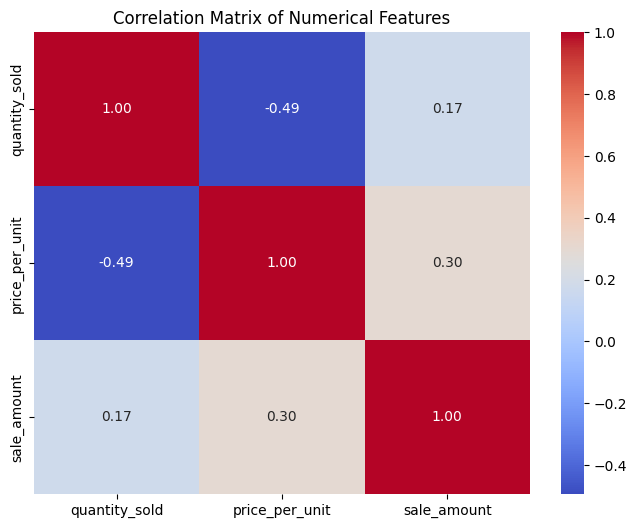

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

There doesn't appear to be a very strong correlation amoung any of the numerical features, the strongest being a -0.49 inverse correlation between ```quantity_sold``` and ```price_per_unit```, which makes sense from the fact that as price of something increases, the lower the volume that item will likely be sold.

Top 10 Products by Sales Amount

In [10]:
product_sales = df.groupby('product_name')['sale_amount'].sum().sort_values(ascending=False).head(10)
product_sales

product_name
Syringes, 50ml            183544.92
Gauze Sponges             105228.59
Surgical Scalpels          99176.40
IV Tubing Set              97378.86
Catheters                  96506.71
Scalpel Blades             96170.81
Suture Kits                95424.80
Forceps                    95195.34
Diagnostic Test Strips     94156.89
Surgical Gowns             93648.31
Name: sale_amount, dtype: float64

Top Regions by Sales Amount

In [11]:
region_sales = df.groupby('region')['sale_amount'].sum().sort_values(ascending=False).head(5)
region_sales

region
West                          726271.13
South                         684853.40
Northeast                     415215.75
Pacific Northwest/Mountain    402079.24
Midwest                       260227.65
Name: sale_amount, dtype: float64

##Visualizing Regional Sales

First, we will split the address column to extract the state only.

In [12]:
df['state'] = df['address'].str.split(', ').str[-1]

Checking all unique values of states

In [13]:
print(df['state'].unique())

['DC' 'IL' 'MN' 'MA' 'CA' 'CO' 'TX' 'FL' 'OR' 'GA' 'WA' 'AZ' 'PA' 'NV'
 'NY']


Next, we'll map states to their respective regions and drop the duplicates to ensure each state is only listed once.

In [14]:
state_to_region = df[['state', 'region']].drop_duplicates().set_index('state')['region'].to_dict()

print(state_to_region)

{'DC': 'Northeast', 'IL': 'Midwest', 'MN': 'Midwest', 'MA': 'Northeast', 'CA': 'West', 'CO': 'Pacific Northwest/Mountain', 'TX': 'South', 'FL': 'South', 'OR': 'Pacific Northwest/Mountain', 'GA': 'South', 'WA': 'Pacific Northwest/Mountain', 'AZ': 'West', 'PA': 'Northeast', 'NV': 'West', 'NY': 'Northeast'}


Mapping regions to the states and creating a heatmap using plotly's choropleth map.

In [15]:
import plotly.express as px

# Mapping States to Regions
state_sales = [{'state': state, 'sale_amount': region_sales[region]}
               for state, region in state_to_region.items()]

state_sales_df = pd.DataFrame(state_sales)

# Create heatmap
fig = px.choropleth(state_sales_df,
                    locations='state',
                    locationmode='USA-states',
                    color='sale_amount',
                    scope='usa',
                    color_continuous_scale='Reds',
                    title='Sales Heatmap by US Region')

fig.show()

As observed, we are missing the majority of states but get an overall grasp on sales data by region where the West shows the highest level of sales and the Midwest has the lowest.

While it's great to observe what regions have the highest sales, let's also determine the growth rate of the regions to see where sales may be growing the most.

In [16]:
# Converting date_of_sale to datetime so we can use it for time series analysis
df['date_of_sale'] = pd.to_datetime(df['date_of_sale'])

# Grouping only year and month together
df['year_month'] = df['date_of_sale'].dt.to_period('M')

Summing sales amount by region for each period

In [17]:
regional_sales = df.groupby(['region', 'year_month'])['sale_amount'].sum().reset_index()

In [18]:
# Calculating percentage growth rate per region
regional_sales['growth_rate'] = regional_sales.groupby('region')['sale_amount'].pct_change() * 100

Add the new Growth Rate feature back into the Dataset

In [19]:
df = df.merge(regional_sales[['region', 'year_month', 'growth_rate']], on=['region', 'year_month'], how='left')
df.head(10)

product_id   company_id transaction_id            product_name  \
0  PMFTMGPWLK  hospital_20     KH9NHAKRFF           Gauze Sponges   
1  B2L09J6I8B     clinic_3     6XGV4E1D36          Scalpel Blades   
2  TLJFSQ5K16    clinic_10     OGEAMK0FW0       Disposable Gloves   
3  3BDN23AHDX   hospital_2     Y68IXY4B8S          Syringes, 50ml   
4  3BDN23AHDX     clinic_8     3GU73WIOON          Syringes, 50ml   
5  PMFTMGPWLK     clinic_5     RGCH2BALOQ           Gauze Sponges   
6  8LZC91NTUT   hospital_6     K1C7WJLZJM          Surgical Gowns   
7  WMHM7GFQTV   hospital_9     V3HQI8R66P  Diagnostic Test Strips   
8  P6HC1OQ4OR    clinic_15     COEHZHPLYW       Ibuprofen Tablets   
9  18MWNDWCBU    clinic_20     BR82Z7JT80         Surgical Gloves   

    product_category  sale_amount  quantity_sold  price_per_unit     uom  \
0    Medical Devices       463.07             85            5.45   packs   
1  Surgical Supplies       387.87             12           32.32  pieces   
2    Medical Devices       336.95             26           12.96   boxes   
3  Surgical Supplies       254.99             17           15.00   boxes   
4    Medical Devices       291.24             66            4.41   boxes   
5    Medical Devices       310.83             45            6.91   packs   
6  Surgical Supplies        62.93             17            3.70   packs   
7    Medical Devices       493.69             52            9.49   boxes   
8    Pharmaceuticals        84.81             47            1.80   packs   
9  Surgical Supplies        88.39             50            1.77   boxes   

           address                      region customer_segment  \
0   Washington, DC                   Northeast         Hospital   
1      Chicago, IL                     Midwest           Clinic   
2  Minneapolis, MN                     Midwest           Clinic   
3       Boston, MA                   Northeast         Hospital   
4  Los Angeles, CA                        West           Clinic   
5       Denver, CO  Pacific Northwest/Mountain           Clinic   
6      Houston, TX                       South         Hospital   
7        Miami, FL                       South         Hospital   
8     Portland, OR  Pacific Northwest/Mountain           Clinic   
9   Washington, DC                   Northeast           Clinic   

       sales_rep_name date_of_sale  multiple_items state year_month  \
0  Christopher Flores   2024-08-05               0    DC    2024-08   
1          John Ponce   2024-04-22               1    IL    2024-04   
2        Thomas Silva   2024-09-30               1    MN    2024-09   
3         Megan Chang   2024-05-20               0    MA    2024-05   
4    William Sullivan   2024-05-13               1    CA    2024-05   
5        Lisa Barrera   2024-03-18               1    CO    2024-03   
6       Daniel Arnold   2024-05-13               1    TX    2024-05   
7        Aaron Snyder   2024-02-26               0    FL    2024-02   
8         Juan Campos   2024-05-06               1    OR    2024-05   
9      Rebecca Wagner   2024-01-22               1    DC    2024-01   

   growth_rate  
0    18.896409  
1    42.673519  
2   -13.995380  
3     9.736326  
4   -10.677634  
5    13.310248  
6   -11.506480  
7   -17.454688  
8    10.761542  
9    24.492621

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   product_id        10000 non-null  object        
 1   company_id        10000 non-null  object        
 2   transaction_id    10000 non-null  object        
 3   product_name      10000 non-null  object        
 4   product_category  10000 non-null  object        
 5   sale_amount       10000 non-null  float64       
 6   quantity_sold     10000 non-null  int64         
 7   price_per_unit    10000 non-null  float64       
 8   uom               10000 non-null  object        
 9   address           10000 non-null  object        
 10  region            10000 non-null  object        
 11  customer_segment  10000 non-null  object        
 12  sales_rep_name    10000 non-null  object        
 13  date_of_sale      10000 non-null  datetime64[ns]
 14  multiple_items    10000

In [21]:
# Checking for missing values in growth rate
print(df['growth_rate'].isnull().sum())

577


Fill in Growth Rate Missing Values with Zeros

We will use zeros so that none of the NaN growth rates factor into our final model.

In [24]:
df.fillna({'growth_rate': 0}, inplace=True)
print(df['growth_rate'].isnull().sum())

0


We'll again visualize but this time with the growth rates.

In [25]:
# First convert the year_month to datetime
regional_sales['year_month'] = regional_sales['year_month'].dt.to_timestamp()

In [26]:
# Plotly line chart
fig = px.line(regional_sales,
              x='year_month',
              y='growth_rate',
              color='region',
              title='Growth Rate of Sales by Region',
              labels={'growth_rate': 'Growth Rate (%)', 'year_month': 'Date'}
)

# Update layout
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    title_font_size=18,
    legend=dict(title='Region'),
    legend_title_font_size=14,
    legend_font_size=12
)

fig.show()


The line chart reglects plenty of peaks and valleys for all regions over the course of nearly a year but there are some key takeaways. The Pacific Northwest/Mountain region started the highest and also dropped to the negative growth range of the lowest regions over the course of a month. The Midwest region seems to have the most volatile rates, reflecting large variances between peaks and valleys compared to all other regions. It also had the most significant increased of any region, showing up in July 2024, but then dropping back down again to near its lowest negative growth rate. At a surface appearance, the West appears to have the most stability, mostly hovering a little negative or positive in growth.

Next, we will visualize the relationships between some of the variables using multivariate analysis.

###Pairplot Between Price Per Unit, Quantity Sold, and Sale Amount

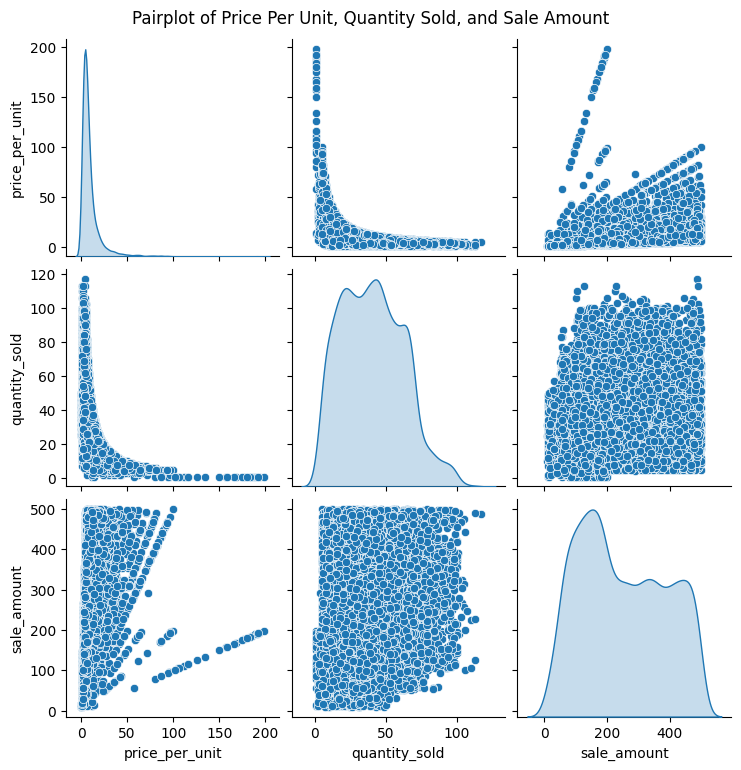

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[['price_per_unit', 'quantity_sold', 'sale_amount']], diag_kind='kde')
plt.suptitle('Pairplot of Price Per Unit, Quantity Sold, and Sale Amount', y=1.02)
plt.show()

There are some clear relationships we can immediately see from the pairplot. It may be stating the obvious to a point, but here we see that the higher the price per unit the lower the quantity of that item sold becomes and vice versa. There also appear to be some linear relationships between price per unit and sale amount where the higher the price per unit the larger the sale amount. This could imply that the quantity sold of certain products may not actually decrease if the price per unit increases, suggesting the product is more non-discretionary or perhaps has fewer alternatives in the market.

##Data Preparation

We're going to set up a target variable first that assigns a territory to a High vs Low sales growth classification. ```pd.qcut``` assigns the data to bins based on equal quantiles, so when we assign ```q=2``` we ensure that there is an equal split between high and low sales growth categories. We are using sales growth so we can see where potentially our sales reps can focus their efforts best.

In [28]:
# Creating target variable to classify High vs Low
df['growth_category'] = pd.qcut(df['growth_rate'], q=2, labels=['Low Growth', 'High Growth'])
df.head(10)

product_id   company_id transaction_id            product_name  \
0  PMFTMGPWLK  hospital_20     KH9NHAKRFF           Gauze Sponges   
1  B2L09J6I8B     clinic_3     6XGV4E1D36          Scalpel Blades   
2  TLJFSQ5K16    clinic_10     OGEAMK0FW0       Disposable Gloves   
3  3BDN23AHDX   hospital_2     Y68IXY4B8S          Syringes, 50ml   
4  3BDN23AHDX     clinic_8     3GU73WIOON          Syringes, 50ml   
5  PMFTMGPWLK     clinic_5     RGCH2BALOQ           Gauze Sponges   
6  8LZC91NTUT   hospital_6     K1C7WJLZJM          Surgical Gowns   
7  WMHM7GFQTV   hospital_9     V3HQI8R66P  Diagnostic Test Strips   
8  P6HC1OQ4OR    clinic_15     COEHZHPLYW       Ibuprofen Tablets   
9  18MWNDWCBU    clinic_20     BR82Z7JT80         Surgical Gloves   

    product_category  sale_amount  quantity_sold  price_per_unit     uom  \
0    Medical Devices       463.07             85            5.45   packs   
1  Surgical Supplies       387.87             12           32.32  pieces   
2    Medical Devices       336.95             26           12.96   boxes   
3  Surgical Supplies       254.99             17           15.00   boxes   
4    Medical Devices       291.24             66            4.41   boxes   
5    Medical Devices       310.83             45            6.91   packs   
6  Surgical Supplies        62.93             17            3.70   packs   
7    Medical Devices       493.69             52            9.49   boxes   
8    Pharmaceuticals        84.81             47            1.80   packs   
9  Surgical Supplies        88.39             50            1.77   boxes   

           address                      region customer_segment  \
0   Washington, DC                   Northeast         Hospital   
1      Chicago, IL                     Midwest           Clinic   
2  Minneapolis, MN                     Midwest           Clinic   
3       Boston, MA                   Northeast         Hospital   
4  Los Angeles, CA                        West           Clinic   
5       Denver, CO  Pacific Northwest/Mountain           Clinic   
6      Houston, TX                       South         Hospital   
7        Miami, FL                       South         Hospital   
8     Portland, OR  Pacific Northwest/Mountain           Clinic   
9   Washington, DC                   Northeast           Clinic   

       sales_rep_name date_of_sale  multiple_items state year_month  \
0  Christopher Flores   2024-08-05               0    DC    2024-08   
1          John Ponce   2024-04-22               1    IL    2024-04   
2        Thomas Silva   2024-09-30               1    MN    2024-09   
3         Megan Chang   2024-05-20               0    MA    2024-05   
4    William Sullivan   2024-05-13               1    CA    2024-05   
5        Lisa Barrera   2024-03-18               1    CO    2024-03   
6       Daniel Arnold   2024-05-13               1    TX    2024-05   
7        Aaron Snyder   2024-02-26               0    FL    2024-02   
8         Juan Campos   2024-05-06               1    OR    2024-05   
9      Rebecca Wagner   2024-01-22               1    DC    2024-01   

   growth_rate growth_category  
0    18.896409     High Growth  
1    42.673519     High Growth  
2   -13.995380      Low Growth  
3     9.736326     High Growth  
4   -10.677634      Low Growth  
5    13.310248     High Growth  
6   -11.506480      Low Growth  
7   -17.454688      Low Growth  
8    10.761542     High Growth  
9    24.492621     High Growth

In [29]:
print(df['growth_category'].value_counts())

growth_category
Low Growth     5220
High Growth    4780
Name: count, dtype: int64


Standardizing the Numerical Features

In [30]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['quantity_sold', 'price_per_unit', 'growth_rate', 'sale_amount']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [31]:
df[numerical_features].isnull().sum()

quantity_sold     0
price_per_unit    0
growth_rate       0
sale_amount       0
dtype: int64

Before we encode our categorical features, let's perform PCA to make sure we're using the most important features as well as not overfitting with any multicollinearity.

##PCA

In [32]:
from sklearn.decomposition import PCA

# Initialize PCA with 95% variance explained
pca = PCA(n_components=0.95, random_state=42)

# Fit and transform
X_pca = pca.fit_transform(df[numerical_features])

# Explained Variance
print('Explained Variance Ratio:', pca.explained_variance_ratio_)
print('Number of Chosen Components:', pca.n_components_)

Explained Variance Ratio: [0.37838967 0.28927003 0.24816669 0.08417361]
Number of Chosen Components: 4


Principal component 1 explains 38% of the variance, PC2 explains 29%, PC3, explains 25%, and PC4 explains only 8%.

Encoding Categorical Features

In [33]:
categorical_features = ['region', 'product_name', 'customer_segment']

df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df_encoded.head()

product_id   company_id transaction_id   product_category  sale_amount  \
0  PMFTMGPWLK  hospital_20     KH9NHAKRFF    Medical Devices     1.579206   
1  B2L09J6I8B     clinic_3     6XGV4E1D36  Surgical Supplies     1.024802   
2  TLJFSQ5K16    clinic_10     OGEAMK0FW0    Medical Devices     0.649399   
3  3BDN23AHDX   hospital_2     Y68IXY4B8S  Surgical Supplies     0.045158   
4  3BDN23AHDX     clinic_8     3GU73WIOON    Medical Devices     0.312407   

   quantity_sold  price_per_unit     uom          address      sales_rep_name  \
0       2.025226       -0.317351   packs   Washington, DC  Christopher Flores   
1      -1.306015        1.713813  pieces      Chicago, IL          John Ponce   
2      -0.667147        0.250347   boxes  Minneapolis, MN        Thomas Silva   
3      -1.077848        0.404555   boxes       Boston, MA         Megan Chang   
4       1.158190       -0.395967   boxes  Los Angeles, CA    William Sullivan   

   ... product_name_Scalpel Blades  product_name_Sterile Drapes  \
0  ...                       False                        False   
1  ...                        True                        False   
2  ...                       False                        False   
3  ...                       False                        False   
4  ...                       False                        False   

  product_name_Surgical Gloves product_name_Surgical Gowns  \
0                        False                       False   
1                        False                       False   
2                        False                       False   
3                        False                       False   
4                        False                       False   

   product_name_Surgical Masks product_name_Surgical Scalpels  \
0                        False                          False   
1                        False                          False   
2                        False                          False   
3                        False                          False   
4                        False                          False   

   product_name_Suture Kits  product_name_Syringes, 50ml  \
0                     False                        False   
1                     False                        False   
2                     False                        False   
3                     False                         True   
4                     False                         True   

   product_name_Vitamin D Capsules  customer_segment_Hospital  
0                            False                       True  
1                            False                      False  
2                            False                      False  
3                            False                       True  
4                            False                      False  

[5 rows x 49 columns]

Feature Matrix and Target

In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Label encoding for sales_category to convert to numerical labels
df_encoded['growth_category_encoded'] = label_encoder.fit_transform(df_encoded['growth_category'])

features = ['quantity_sold', 'price_per_unit', 'growth_rate', 'sale_amount',
            'region_West','region_South','region_Northeast', 'region_Pacific Northwest/Mountain', 'multiple_items']
X = df_encoded[features]
y = df_encoded['growth_category_encoded']

Splitting the data into training and testing sets

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

Since we are trying to categorize our data into sales by using high and low sales categories, we want to use classifiers to help us break down where each data point gets categorized. To do this, I'll build both a Decisiong Tree and a RandomForest classifier and compare which classifier performs better to help develop the model that initially performs stronger.

##Decision Tree Classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize and train Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

# Perform Cross-Validation with 5 folds
cv_scores = cross_val_score(tree, X_train, y_train, cv=5)

# Make predictions
y_pred_tree = tree.predict(X_test)

# Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

# Cross-Val Results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Decision Tree Accuracy: 0.9856666666666667
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1467
           1       0.98      0.99      0.99      1533

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Cross-Validation Scores: [0.98357143 0.98071429 0.97857143 0.97714286 0.98357143]
Mean Cross-Validation Score: 0.9807142857142856


The decision tree performed fairly well with these hyperparameters across 5 folds with a mean score of over 98%.

##RandomForest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=5).fit(X_train, y_train)

# Perform Cross-Validation with 5 folds
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Cross-Val Results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Random Forest Accuracy: 0.9853333333333333
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1467
           1       0.98      0.99      0.99      1533

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Cross-Validation Scores: [0.98142857 0.98642857 0.98428571 0.98857143 0.98857143]
Mean Cross-Validation Score: 0.9858571428571429


Our Random Forest Classifier performs the same as the Decision Tree at over 98% accuracy. The mean cross-validation score though is slightly better than the Decision Tree with 98.6% vs 98.1%. Due to the slight improvement, we'll use the Random Forest Classifier as our model of choice for this dashboard.

Now we will use the full dataset to predict what growth category all geographic locations should classify inside.

In [38]:
df_encoded['predicted_growth_category'] = rf.predict(X_pca)
df_encoded['predicted_growth_category_label'] = label_encoder.inverse_transform(df_encoded['predicted_growth_category'])

In [39]:
#Mapping predictions to original DF
df['predicted_growth_category'] = df_encoded['predicted_growth_category_label']

Now we will use the new mappings to aggregate the predicted high-growth sales by state.

In [43]:
state_growth = df[df['predicted_growth_category'] == 'High Growth'].groupby('state')['sale_amount'].sum().reset_index()
state_growth

state  sale_amount
0     AZ    -7.870297
1     CA    -5.376704
2     CO    27.452824
3     DC   -18.802432
4     FL    15.963834
5     GA    -6.910650
6     IL     3.630525
7     MA     0.421580
8     MN    38.430869
9     NV   -18.045810
10    NY     6.343144
11    OR    22.107743
12    PA     4.470057
13    TX   -42.840328
14    WA     6.678752

##Update Choropleth Map

In [44]:
all_states = pd.DataFrame(df['state'].unique(), columns=['state'])
state_growth = all_states.merge(state_growth, on='state', how='left').fillna(0)

# Map data
fig = px.choropleth(state_growth,
                    locations='state',
                    locationmode='USA-states',
                    color='sale_amount',
                    scope='usa',
                    color_continuous_scale='Reds',
                    title='Predicted High Growth Sales by State')

fig.show()

Based on our new map, we now have a solid predictor of where to focus our efforts further. Each region, regardless of how sales have historically done across the region as a whole, seems to contain at least one state where we can make sure sales reps are focusing resources to continue growing those sales even further.

##References

Plotly. (n.d.). *Line charts in Python*. Plotly. Retrieved November 21, 2024, from https://plotly.com/python/line-charts/

Plotly. (n.d.). *Tile Choropleth Maps in Python*. Retrieved November 22, 2024, from https://plotly.com/python/tile-county-choropleth/

##Personal Contribution Statement
This notebook was completed solely by me as part of the larger dashboard we are producing for our team project. We split the dashboard into different sections and each took a piece of the dashboard to work on the respective modeling techniques and tasks. I am developing the dashboard section for optimizing sales territories, while Owen and Erik both have their own respective notebooks for their parts, and will be submitting their respective notebooks separately.